# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"

boston = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([boston.values[::2, :], boston.values[1::2, :2]])
y = boston.values[1::2, 2]

In [8]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [10]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

np.float64(33.9776023899853)

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    n = X.shape[0]
    preds_sum = np.zeros(n)
    preds_sq_sum = np.zeros(n)
    counts = np.zeros(n)
    squared_error_sum = 0.0
    total_predictions = 0
    for _ in range (num_runs):
        
            
        indices = np.random.choice(n, n, replace=True)
        X_boot = X[indices]
        Y_boot = y[indices]

        regressor.fit(X_boot, Y_boot)
        oob_indices = np.setdiff1d(np.arange(n), indices)
        X_oob = X[oob_indices]
        y_oob = y[oob_indices]
        y_pred = regressor.predict(X_oob)

        preds_sum[oob_indices] += y_pred
        preds_sq_sum[oob_indices] += y_pred ** 2
        counts[oob_indices] += 1
        squared_error_sum += np.sum((y_oob - y_pred) ** 2)
        total_predictions += len(oob_indices)


    

    variance = np.mean((preds_sq_sum / counts) - (preds_sum / counts) ** 2)
    bias = np.mean((y - (preds_sum / counts)) ** 2)
    error = squared_error_sum / total_predictions
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
regressor = DecisionTreeRegressor(max_depth=5)
bias, variance, error = compute_biase_variance(regressor, X, y, num_runs=100)
print(f"Bias: {bias}, Variance: {variance}, Error: {error}")

linear_regressor = LinearRegression()
bias, variance, error = compute_biase_variance(linear_regressor, X, y, num_runs=100)
print(f"Bias: {bias}, Variance: {variance}, Error: {error}")

rf_regressor = RandomForestRegressor(n_estimators=10, max_depth=5)
bias, variance, error = compute_biase_variance(rf_regressor, X, y, num_runs=100)
print(f"Bias: {bias}, Variance: {variance}, Error: {error}")

Bias: 12.32955376419056, Variance: 9.4634670251508, Error: 21.692740537970327
Bias: 23.592051858862053, Variance: 0.860027477016837, Error: 24.834577855173414
Bias: 11.813646683456279, Variance: 2.9200510325023235, Error: 14.727637491043582


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

Линейная регрессия имеет наибольшее смещение и наименьший разброс, что соответствует недообучению: модель слишком простая и плохо аппроксимирует зависимость.

Решающее дерево демонстрирует меньшее смещение, но значительно больший разброс, что характерно для переобучения и высокой чувствительности к выборке.

Случайный лес снижает разброс по сравнению с одиночным деревом за счёт ансамблирования, сохраняя при этом небольшое смещение, что приводит к наименьшей общей ошибке среди рассмотренных моделей.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [38]:
def model_bagging(X, y, num_runs):
    n = X.shape[0]
    preds_sum = np.zeros(n)
    preds_sq_sum = np.zeros(n)
    counts = np.zeros(n)
    squared_error_sum = 0.0
    total_predictions = 0
    for _ in range (num_runs):
        indices = np.random.choice(n, n, replace=True)
        X_boot = X[indices]
        Y_boot = y[indices]

        oob_indices = np.setdiff1d(np.arange(n), indices)
        X_oob = X[oob_indices]
        y_oob = y[oob_indices]

        rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=5)
        rf_regressor.fit(X_boot, Y_boot)
        y_pred = rf_regressor.predict(X_oob)
        

        linear_regressor = LinearRegression()
        linear_regressor.fit(X_boot, Y_boot)
        y_lin_pred = linear_regressor.predict(X_oob)   

        tree_regressor = DecisionTreeRegressor()
        tree_regressor.fit(X_boot, Y_boot)
        y_tree_pred = tree_regressor.predict(X_oob)

        ensemble_pred = (y_pred + y_lin_pred + y_tree_pred) / 3

        preds_sum[oob_indices] += ensemble_pred
        preds_sq_sum[oob_indices] += ensemble_pred ** 2
        counts[oob_indices] += 1
        squared_error_sum += np.sum((y_oob - ensemble_pred) ** 2)
        total_predictions += len(oob_indices)

    variance = np.mean((preds_sq_sum / counts) - (preds_sum / counts) ** 2)
    bias = np.mean((y - (preds_sum / counts)) ** 2)
    error = squared_error_sum / total_predictions
    
    return bias, variance, error


bias, variance, error = model_bagging(X, y, num_runs=100)
print(f"Bagging Ensemble - Bias: {bias}, Variance: {variance}, Error: {error}")

Bagging Ensemble - Bias: 11.719790188509633, Variance: 2.446556995178253, Error: 14.133672656043847


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [51]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """

    all_preds = [[] for _ in range(num_test_objects)]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    n_train = X_train.shape[0]
    for _ in range(num_runs):
        indices = np.random.choice(n_train, n_train, replace=True)
        X_boot = X_train[indices]
        Y_boot = y_train[indices]
        regressor.fit(X_boot, Y_boot)
        y_pred = regressor.predict(X_test)
        for i in range(num_test_objects):
            all_preds[i].append(y_pred[i])


    plt.figure(figsize=(10, 6))

    for i in range(num_test_objects):
        x = np.full(len(all_preds[i]), i)  # вертикальный столбик
        plt.scatter(x, all_preds[i], alpha=0.5)

    # истинные значения
    plt.scatter(
        range(num_test_objects),
        y_test,
        color="black",
        s=80,
        label="True value"
    )

    plt.xlabel("Test object index")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.show()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

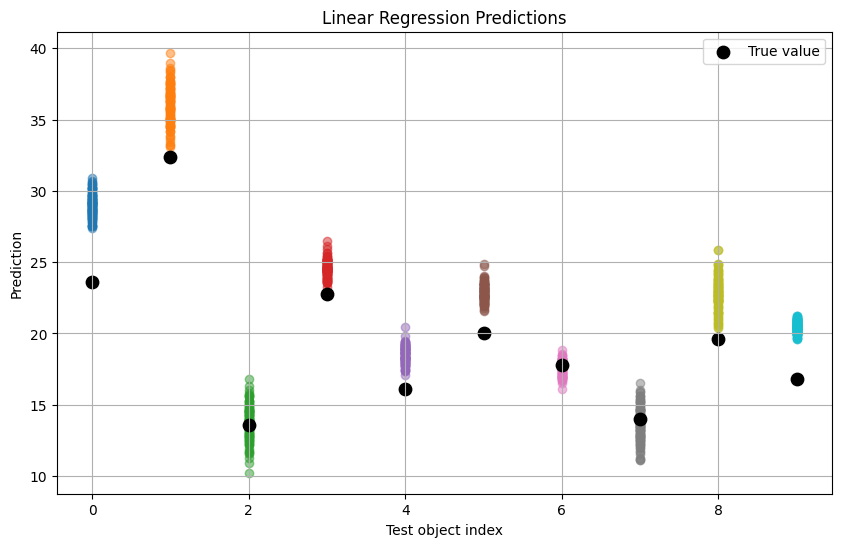

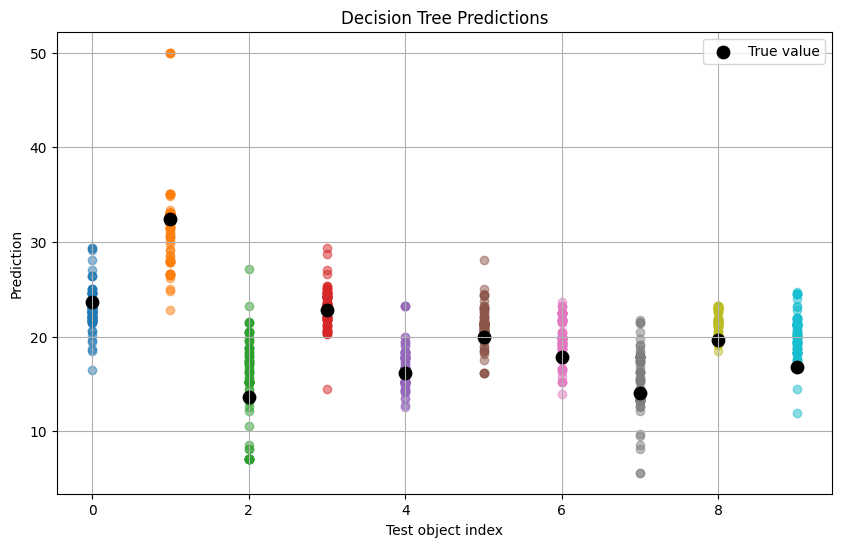

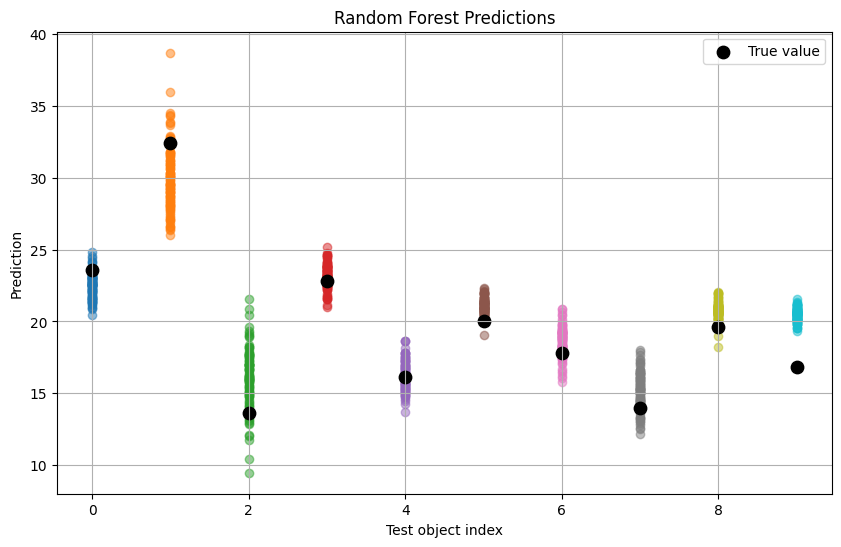

In [41]:
linear_regressor = LinearRegression()
plot_predictions(linear_regressor, X, y, title="Linear Regression Predictions")

tree_regressor = DecisionTreeRegressor()
plot_predictions(tree_regressor, X, y, title="Decision Tree Predictions")

rf_regressor = RandomForestRegressor(n_estimators=10, max_depth=5)
plot_predictions(rf_regressor, X, y, title="Random Forest Predictions")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

то же самое что сверху

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

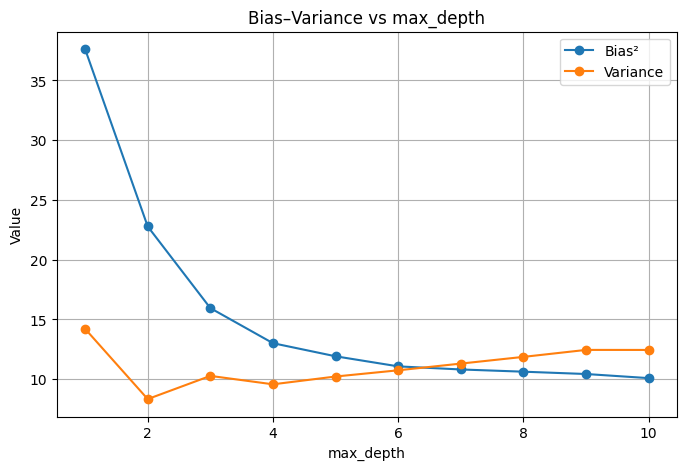

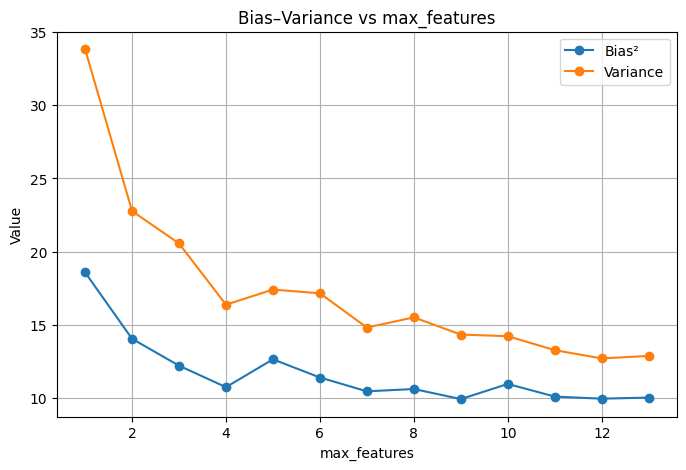

In [49]:
depths = range(1, 11)
biases = []
variances = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    b, v, error = compute_biase_variance(model, X, y)
    biases.append(b)
    variances.append(v)

plt.figure(figsize=(8, 5))
plt.plot(depths, biases, label="Bias²", marker="o")
plt.plot(depths, variances, label="Variance", marker="o")
plt.xlabel("max_depth")
plt.ylabel("Value")
plt.title("Bias–Variance vs max_depth")
plt.legend()
plt.grid(True)
plt.show()


max_feats = range(1, X.shape[1] + 1)
biases = []
variances = []

for mf in max_feats:
    model = DecisionTreeRegressor(
        max_features=mf,
        random_state=42
    )
    b, v, error = compute_biase_variance(model, X, y)
    biases.append(b)
    variances.append(v)

plt.figure(figsize=(8, 5))
plt.plot(max_feats, biases, label="Bias²", marker="o")
plt.plot(max_feats, variances, label="Variance", marker="o")
plt.xlabel("max_features")
plt.ylabel("Value")
plt.title("Bias–Variance vs max_features")
plt.legend()
plt.grid(True)
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

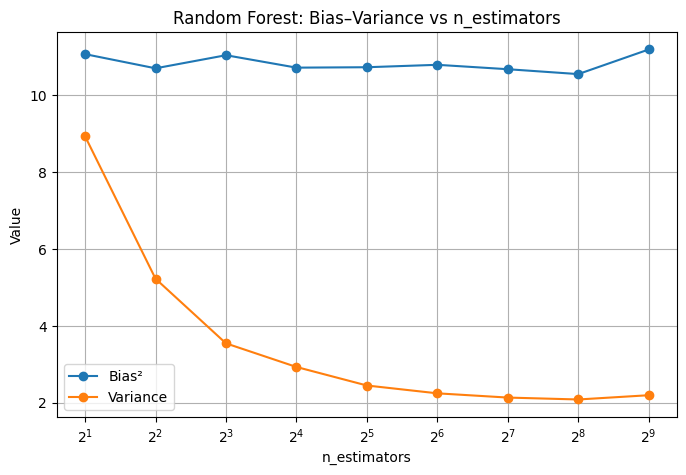

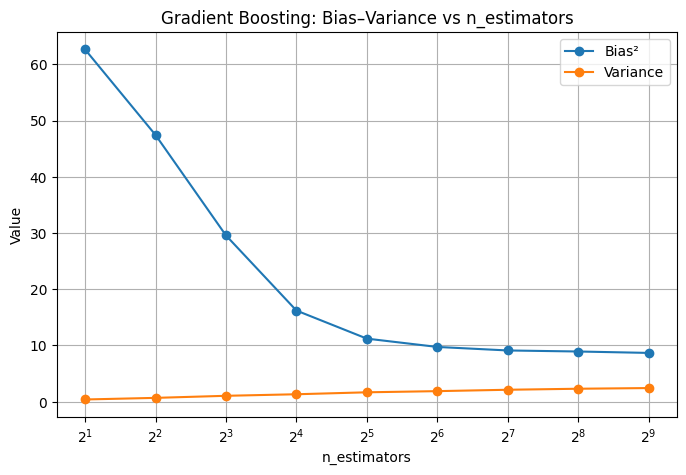

In [53]:
n_estimators_grid = 2 ** np.arange(1, 10)

rf_biases = []
rf_variances = []

for n in n_estimators_grid:
    model = RandomForestRegressor(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    b, v, error = compute_biase_variance(model, X, y, num_runs=150)
    rf_biases.append(b)
    rf_variances.append(v)

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_grid, rf_biases, label="Bias²", marker="o")
plt.plot(n_estimators_grid, rf_variances, label="Variance", marker="o")
plt.xscale("log", base=2)
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.title("Random Forest: Bias–Variance vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.ensemble import GradientBoostingRegressor

gb_biases = []
gb_variances = []

for n in n_estimators_grid:
    model = GradientBoostingRegressor(
        n_estimators=n,
        random_state=42
    )
    b, v, error = compute_biase_variance(model, X, y, num_runs=150)
    gb_biases.append(b)
    gb_variances.append(v)

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_grid, gb_biases, label="Bias²", marker="o")
plt.plot(n_estimators_grid, gb_variances, label="Variance", marker="o")
plt.xscale("log", base=2)
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.title("Gradient Boosting: Bias–Variance vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()


__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

## max_depth
Что видно на графике
- Bias² резко падает при увеличении max_depth
- Variance растёт при больших глубинах
- Есть область компромисса (примерно max_depth ≈ 5–7)

Почему так происходит

Маленькая глубина (max_depth = 1–2)
- Дерево очень простое
- Делает грубые разбиения
- Не способно аппроксимировать сложную зависимость

Большая глубина
- Начинается переобучение

## max_features
- При малом значении дерево делает неоптимальные разбиения, с увеличением количества деревья становятся более похожими. 

## random forest/ n_estimators

- bias не меняется
- variance падает при росте n n_estimators 

*Random Forest — variance-reduction алгоритм*

## gb/ n_estimators

- bias резко падает
- variance медленно растет

Каждая новая модель исправляет ошибки предыдущих -> bias уменьшается 


